# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


## Imports & constants

In [2]:
from mobilkit.umni import * # t=0:55, 2:43

In [3]:
from scipy.optimize import curve_fit

## Control parameters

In [4]:
# spatial scales of the maps
SCALES = ("BG", "COUNTY", "TRACT")

In [5]:
# travel modes considered
MODES = ("BIKE", "DRIVE", "TRANSIT", "WALK")

In [6]:
# travel time thresholds (minutes)
TT_THRESHOLDS = (15, 30, 45, 60)

# Load data

## Zones (TIGER)

In [7]:
year = 2010
zones = pd.concat([
    gpd.read_parquet(f'../data/zones/{scale.lower()}_{year}.parquet')
    .set_crs(CRS_DEG).assign(scale=scale) for scale in SCALES
]).reset_index(drop=True).astype({'scale': 'category'}).disp()

6,417 rows x 6 cols; Memory: 1.0 MiB; CRS: EPSG:4326


geoid           name    aland   awater  \
       <object>       <object>  <int64>  <int64>   
0  181379685003  Block Group 3  2566010    39626   

                                            geometry       scale  
                                          <geometry>  <category>  
0  POLYGON ((-85.20815 39.304011, -85.208134 39.3...          BG

## Census (ACS)

In [8]:
year = 2013
nchar = {'BG': 12, 'TRACT': 11, 'COUNTY': 5}
acs = pd.concat([
    pd.read_csv(f'../data/acs/acs_{year}.csv')
    .assign(geoid=lambda df: df.geoid.astype(str).str[:nchar[scale]])
    .groupby('geoid').sum().assign(scale=scale)
    for scale in SCALES
]).reset_index().astype({'scale': 'category'}).disp()

6,405 rows x 34 cols; Memory: 2.0 MiB


geoid       popu         hh  age_minor  age_adult age_senior  \
       <object>  <float64>  <float64>  <float64>  <float64>  <float64>   
0  180010301001      850.0      317.0      100.0      568.0      157.0   

  age_median sex_female   sex_male race_white race_black edu_eligible  \
   <float64>  <float64>  <float64>  <float64>  <float64>    <float64>   
0       48.2      432.0      418.0      850.0        0.0        619.0   

  edu_bachelors employ_total employ_in_LF employ_not_in_LF   inc_total  \
      <float64>    <float64>    <float64>        <float64>   <float64>   
0         106.0        534.0        573.0            185.0  22124500.0   

     inc_avg inc_total_hh inc_median   pop_poor pop_nonpoor    hh_poor  \
   <float64>    <float64>  <float64>  <float64>   <float64>  <float64>   
0    26029.0   22090100.0    55787.0        0.0         0.0        0.0   

  hh_nonpoor     cm_car    cm_pool      cm_pt     cm_bus  cm_subway  \
   <float64>  <float64>  <float64>  <float64>  <float64>  <float64>   
0      317.0      461.0       17.0        0.0        0.0        0.0   

     cm_taxi    cm_bike    cm_walk     cm_wfm       scale  
   <float64>  <float64>  <float64>  <float64>  <category>  
0        0.0        0.0       15.0      478.0          BG

## POIs (SafeGraph)

In [9]:
pois = (gpd.read_parquet('../data/pois/safegraph.parquet')
        .set_crs(CRS_DEG)).disp()

59,308 rows x 9 cols; Memory: 14.6 MiB; CRS: EPSG:4326


id         name        lon        lat  area_sqft  \
              <object>     <object>  <float32>  <float32>  <float64>   
0  222-222@5pt-wkn-26k  Davis Drugs -87.250046  40.292645     5454.0   

      visits   visitors  category                      geometry  
   <float64>  <float64>  <object>                    <geometry>  
0      211.0      120.0   Medical  POINT (-87.250046 40.292645)

## Travel times
Distance/time between each OD pair

In [10]:
od = []
for f in Path('../data/travel_time').glob('*.csv'):
    scale, mode, day_type = f.stem.split('.')[0].split('__')
    if day_type == 'weekend': continue
    df = pd.read_csv(f).assign(scale=scale.upper(), mode={
        'driving': 'DRIVE', 'bicycling': 'BIKE',
        'transit': 'TRANSIT', 'walking': 'WALK'}[mode])
    od.append(df.assign(time=df.time / 60)) # convert to minutes
od = pd.concat(od).reset_index(drop=True)
od = od.astype({'scale': 'category', 'mode': 'category'}).disp()

7,620,668 rows x 8 cols; Memory: 312.5 MiB


src_geoid    trg_geoid       dist       time      ok      speed  \
       <int64>      <int64>  <float64>  <float64>  <bool>  <float64>   
0  18105001304  18105001301     4480.0  54.466667    True   1.370869   

        scale        mode  
   <category>  <category>  
0       TRACT        WALK

# Modified E2SFCA
[Original E2SFCA paper](https://www.sciencedirect.com/science/article/pii/S1353829209000574?casa_token=R-O3z17sKz4AAAAA:BXZX0J2mjBUAl2Oj1YpRFlBkF03AwLcSVvW8g_Iun-9LQdKii14QdmkOpu8EDliHW_wTZ8Ddow)

## Travel time weight functions

### Driving
Cost impedance function for driving based on the E2SFCA formula in the project report.
$$ w(t) = \begin{cases} 1 & t\le 28\;\text{min} \\ \exp{\left(-\frac{1}{2}\left(\frac{t-28}{20}\right)^2\right)} & t>28\;\text{min} \end{cases} $$

In [11]:
def get_cost_drive(time: pd.Series, vmin=28, vmax=60, sd=20):
    cost = np.exp(-0.5 * ((time - vmin) / sd) ** 2)
    cost.loc[time <= vmin] = 1
    cost.loc[time >= vmax] = 0
    return cost

/tmp/ipykernel_4252/1206783263.py:11: RuntimeWarning: divide by zero encountered in power
  f = lambda x, a, b: np.exp(-x**a / b)


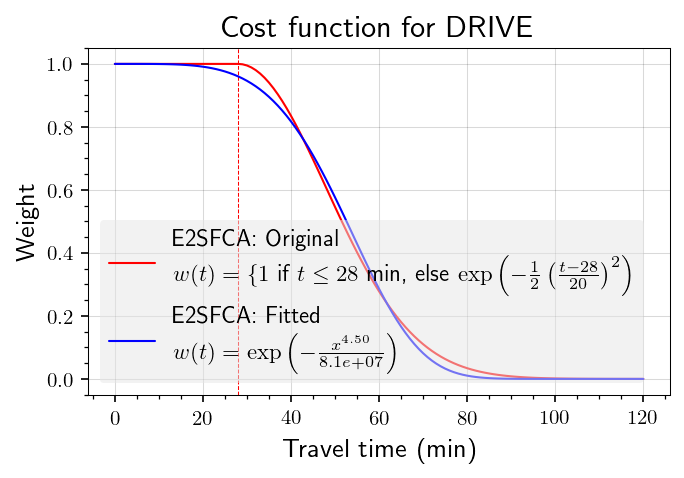

In [12]:
mpl.rc('text', usetex=True)
# with plt.rc_context({'text.latex.preamble': [r'\usepackage{amsmath}']}):
ax = U.plot(size=(5, 3), xlab='Travel time (min)', ylab='Weight', title='Cost function for DRIVE')
x = np.arange(121)
y = np.exp(-0.5*(x-28)**2/20**2)
y[x <= 28] = 1
# formula = r'w(t) =\begin{cases} 1 & t\le 28 \\ \exp{\left(-\frac{1}{2}\left(\frac{t-28}{20}\right)^2\right)} & t>28 \end{cases}'
formula = r'$w(t)=\{1$ if $t\le 28$ min, else $\exp{\left(-\frac{1}{2}\left(\frac{t-28}{20}\right)^2\right)}$'
ax.plot(x, y, 'r', lw=1, label=f'E2SFCA: Original\n{formula}')
ax.axvline(28, ls='--', color='r', lw=0.5)
f = lambda x, a, b: np.exp(-x**a / b)
a, b = curve_fit(f, x, y)[0]
formula = r'$w(t)=\exp\left({-\frac{x^{%.2f}}{%.1e}}\right)$' % (a, b)
# formula = 'asdsd'
ax.plot(x, f(x, a, b), 'b', lw=1, label=f'E2SFCA: Fitted\n{formula}')
ax.legend(loc='lower left');

### Walking
Cost impedance function for walking, based on the WalkScore weight step function (**reference?**).

In [13]:
def get_cost_walk(time: pd.Series,
                  bin_start=(0, 5, 10, 15, 20, 25, 30),
                  weights=(1., .88, .60, .25, .075, .045, 0)):
    return pd.cut(time, bins=list(bin_start) + [np.inf],
                  labels=weights, right=False).astype(float)

/tmp/ipykernel_4252/2080796086.py:4: RuntimeWarning: divide by zero encountered in power
  f = lambda x, a, b: np.exp(-x**a / b)


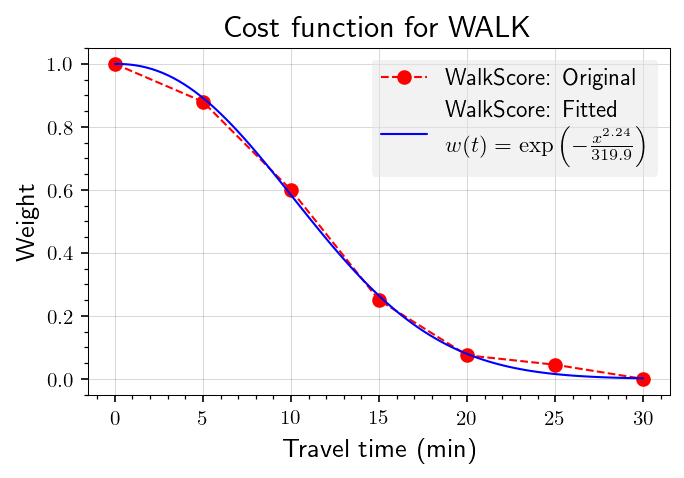

In [14]:
ax = U.plot(size=(5, 3), xlab='Travel time (min)', ylab='Weight', title='Cost function for WALK')
x, y = (0, 5, 10, 15, 20, 25, 30), (1., .88, .60, .25, .075, .045, 0)
ax.plot(x, y, '--ro', lw=1, label='WalkScore: Original')
f = lambda x, a, b: np.exp(-x**a / b)
a, b = curve_fit(f, x, y)[0]
# a, b = 2.16, 267.4
formula = r'$w(t)=\exp\left({-\frac{x^{%.2f}}{%.1f}}\right)$' % (a, b)
x = np.linspace(0, 30, 100)
ax.plot(x, f(x, a, b), 'b', lw=1, label=f'WalkScore: Fitted\n{formula}')
ax.legend();

## POI importance weighting

In [15]:
def get_poi_weights(pois, method, log=True, eps=1e-6):
    """
    The method for weighting POIs (not every POI is created equal).
    Inputs:
        - pois: DataFrame containing info for each POI
        - method: One of the different ways of weighting POIs
        - log: Whether log-transform columns to reduce skewing of result
    Output:
        - the input DataFrame with an additional POI weights column
    """
    poi_cols = ['area_sqft', 'visits', 'visitors']
    pois = pois.fillna(0) # to ensure no POI weight is NaN
    if log:
        for col in poi_cols:
            pois[col] = np.log10(1 + pois[col])
    weights = {
        'COUNT': 1,
        'VISITS': pois['visits'],
        'VISITORS': pois['visitors'],
        'AREA': pois['area_sqft'],
        'AREA_X_VISITS': pois['area_sqft'] * pois['visits'],
        'VISIT_DENSITY': pois['visits'] / (pois['area_sqft'] + eps),
        'VISITOR_DENSITY': pois['visitors'] / (pois['area_sqft'] + eps)
    }[method]
    return pois.assign(weight=weights)

## Impact of population at destination
This is the controversial inclusion of (weighted) population in the denominator of the attractiveness (facility ratio) in the E2SFCA calculation.

In [16]:
def get_popu_weights(zones, od):
    """
    Inputs:
        - zones: Zones containing population information
        - od: Table containing travel time cost for each OD pair
    """
    popu = zones.set_index('geoid')['popu'].reset_index()
    od = od.merge(popu, left_on='src_geoid', right_on='geoid')
    od['wtd_popu'] = od['cost'] * od['popu']
    weights = od.groupby('trg_geoid')['wtd_popu'].sum().rename_axis('geoid')
    return weights

## Compute accessibility

In [17]:
def get_poi_access(scale: str, mode: str, tt_max: float,
                   zones=zones, acs=acs, pois=pois, od=od,
                   poi_weight_method='COUNT',
                   source_popu=True, target_popu=False):
    """
    Get POI accessibility using the gravity-like E2SFCA metric.
    Inputs:
        - scale: Scale of operation
        - mode: Travel mode (currently supports only DRIVE & WALK)
        - tt_thresh: Travel time threshold (minutes)
        - zones: Table of zones for all scales
        - acs: ACS data table for all zones having at least population
        - pois: Table of POIs containing at least POI category & other 
            attributes (such as area or visits) for computing weight
        - od: Table of travel time for all OD pairs
        - poi_weight_method: One of the methods used to weight POIs
        - source_popu: Whether divide the final accessibility of 
            a zone by its population
        - target_popu: Whether divide the destination zone's 
            attractiveness by its catchment population
    """
    # filter census & zone boundary data for the given scale
    acs = acs[acs['scale'] == scale][['geoid', 'popu']]
    zones = zones[zones['scale'] == scale][['geoid', 'geometry']]
    # get population for each zone
    zones = zones.merge(acs, on='geoid')
    # get weight of each POI
    pois = (get_poi_weights(pois, poi_weight_method)
            .rename(columns={'category': 'poi_kind', 'weight': 'poi_wt'})
            [['geometry', 'poi_kind', 'poi_wt']])
    # get attractiveness of each zone for each POI category
    attract = (zones.sjoin(pois).groupby(['geoid', 'poi_kind'])
               ['poi_wt'].sum().reset_index())
    # filter travel times for given mode, scale & travel time threshold
    od = od.query('scale=="{}" & mode=="{}" & time<={}'.format(
        scale, mode, tt_max)).reset_index(drop=True)
    # assign travel time-based cost to each OD pair for the given mode
    od['cost'] = {'DRIVE': get_cost_drive,
                  'WALK': get_cost_walk
                 }[mode](od['time'])
    od = od.astype({'src_geoid': str, 'trg_geoid': str})
    od = od[['src_geoid', 'trg_geoid', 'cost']]
    # if needed, update the destinations' attractiveness by 
    # dividing by the weighted population
    if target_popu:
        popu_wts = get_popu_weights(zones, od)
        attract = attract.merge(popu_wts, on='geoid')
        attract['poi_wt'] /= (attract.pop('wtd_popu') / 1e6)
    # accessibility = cost-weighted sum of destinations' attractiveness
    od = od.merge(attract, left_on='trg_geoid', right_on='geoid')
    od['access'] = od['poi_wt'] * od['cost']
    access = (od.groupby(['src_geoid', 'poi_kind'])['access']
              .sum().reset_index().rename(columns={'src_geoid': 'geoid'}))
    # if needed, compute accessibility per person in each zone
    if source_popu:
        access = access.merge(acs, on='geoid')
        access['access'] /= access.pop('popu')
    return access

xs = get_poi_access('BG', 'DRIVE', 30).disp()

33,647 rows x 3 cols; Memory: 4.6 MiB


geoid   poi_kind     access
       <object>   <object>  <float64>
0  180010301001  Education   0.168146

# Visualize

In [18]:
def plot_map_poi_access(scale, mode, tt_thresh, poi_kind=None, zones=zones,
                        cmap='rainbow', dpi=120, vmin=None, vmax=None, **kwargs):
    xs = get_poi_access(
        scale, mode, tt_thresh, **kwargs)
    xs = zones[['geoid', 'geometry']].merge(xs, on='geoid')
    if isinstance(poi_kind, str):
        xs = xs.query(f'poi_kind=="{poi_kind}"')
    cnty = zones.query('scale=="COUNTY"')
    title = 'Accessibility to {} POIs at {}\n scale within {} minutes by {}'.format(
        poi_kind if poi_kind else 'all', scale, tt_thresh, mode)
    ax = U.plot(size=(8, 16), dpi=dpi, axoff=1, title=title)
    xs.plot(ax=ax, column='access', cmap=cmap, legend=True,
            edgecolor='k', lw=0.1, vmin=vmin, vmax=vmax, legend_kwds=dict(
                shrink=0.4, label='POI accessibility'))
    cnty.plot(ax=ax, ec='k', lw=1, facecolor='none')

CPU times: user 8.9 s, sys: 1.27 s, total: 10.2 s
Wall time: 10.1 s


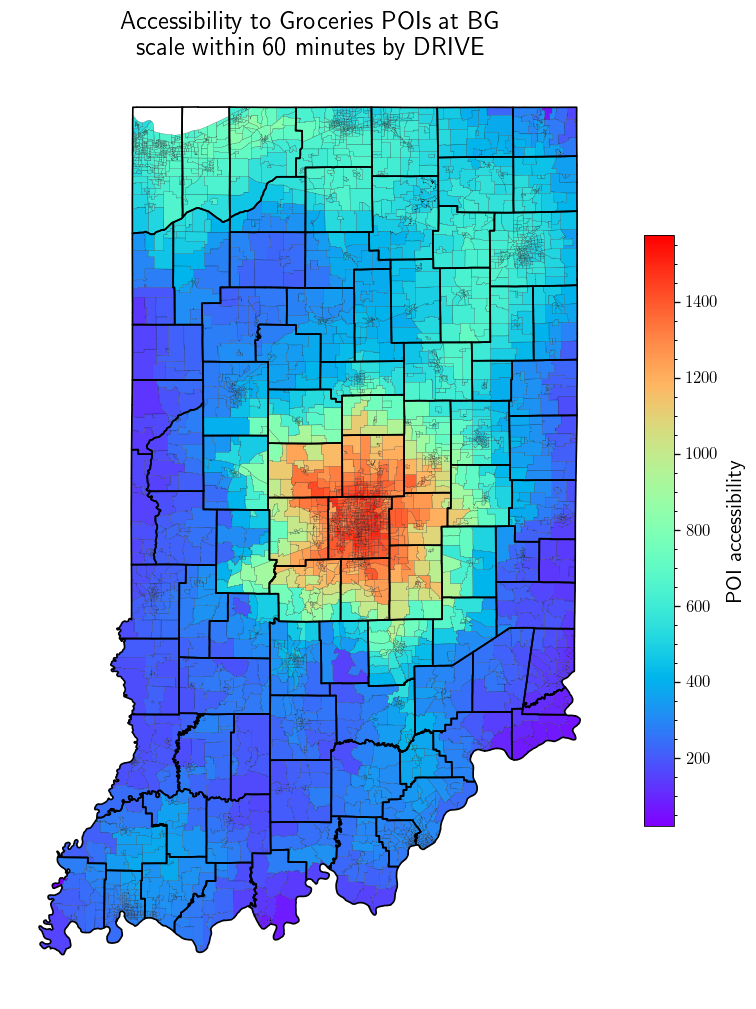

In [19]:
%time plot_map_poi_access('BG', 'DRIVE', 60, 'Groceries', source_popu=False)

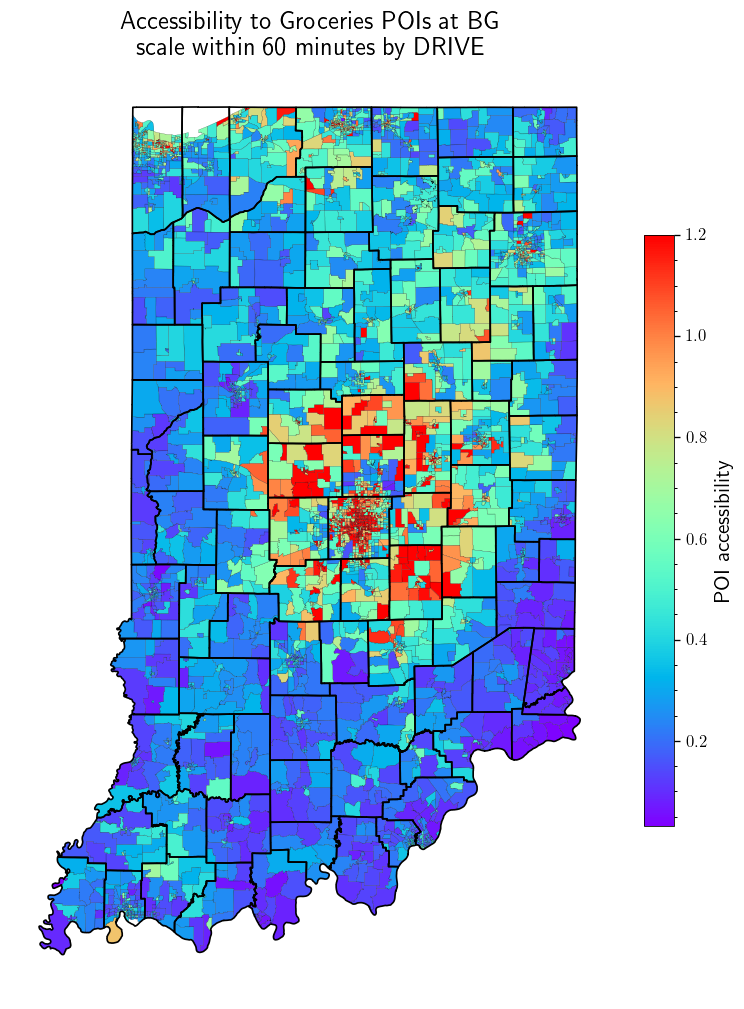

In [20]:
plot_map_poi_access('BG', 'DRIVE', 60, 'Groceries', source_popu=True, vmax=1.2)

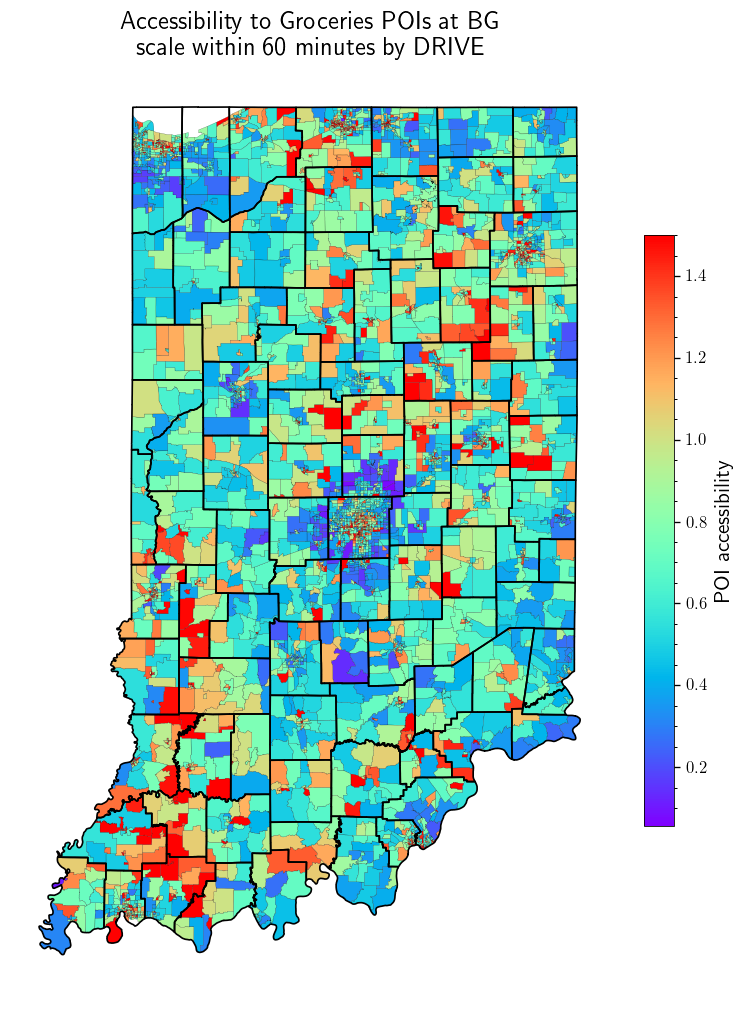

In [21]:
plot_map_poi_access('BG', 'DRIVE', 60, 'Groceries', vmax=1.5, target_popu=True)

CPU times: user 4.83 s, sys: 385 ms, total: 5.21 s
Wall time: 5.06 s


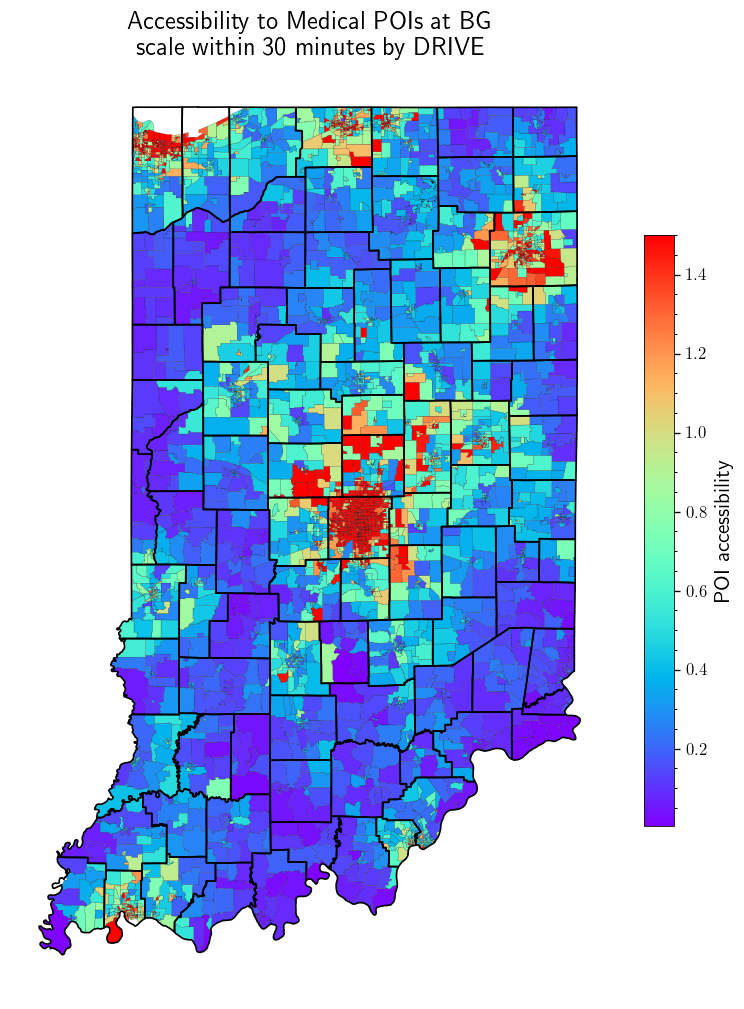

In [22]:
%time plot_map_poi_access('BG', 'DRIVE', 30, 'Medical', vmax=1.5, poi_weight_method='VISITS')

CPU times: user 4.85 s, sys: 355 ms, total: 5.2 s
Wall time: 5.06 s


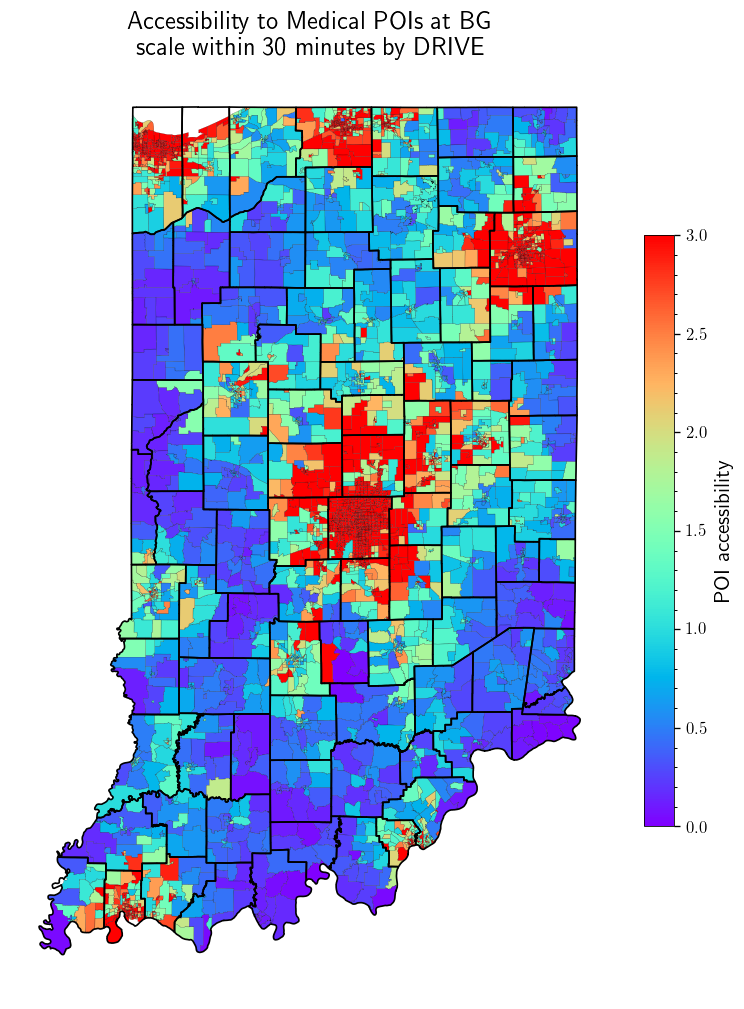

In [23]:
%time plot_map_poi_access('BG', 'DRIVE', 30, 'Medical', vmax=3, poi_weight_method='AREA')

CPU times: user 4.69 s, sys: 378 ms, total: 5.07 s
Wall time: 4.92 s


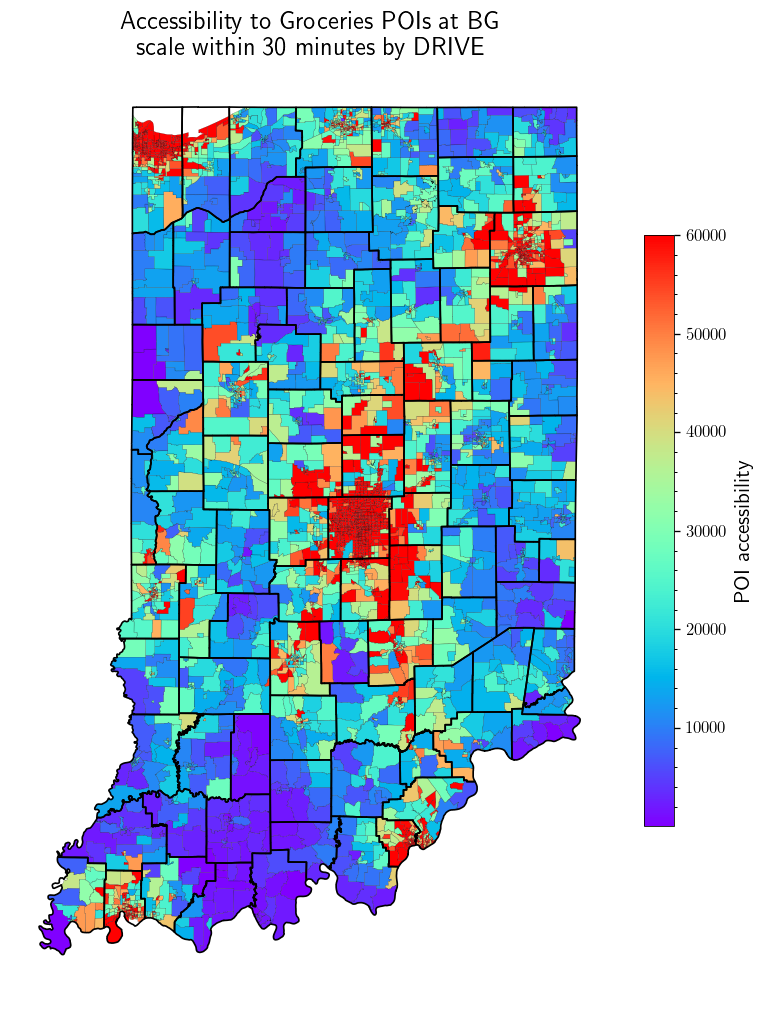

In [24]:
%time plot_map_poi_access('BG', 'DRIVE', 30, 'Groceries', vmax=6e4, poi_weight_method='VISIT_DENSITY')

CPU times: user 4.84 s, sys: 327 ms, total: 5.17 s
Wall time: 5 s


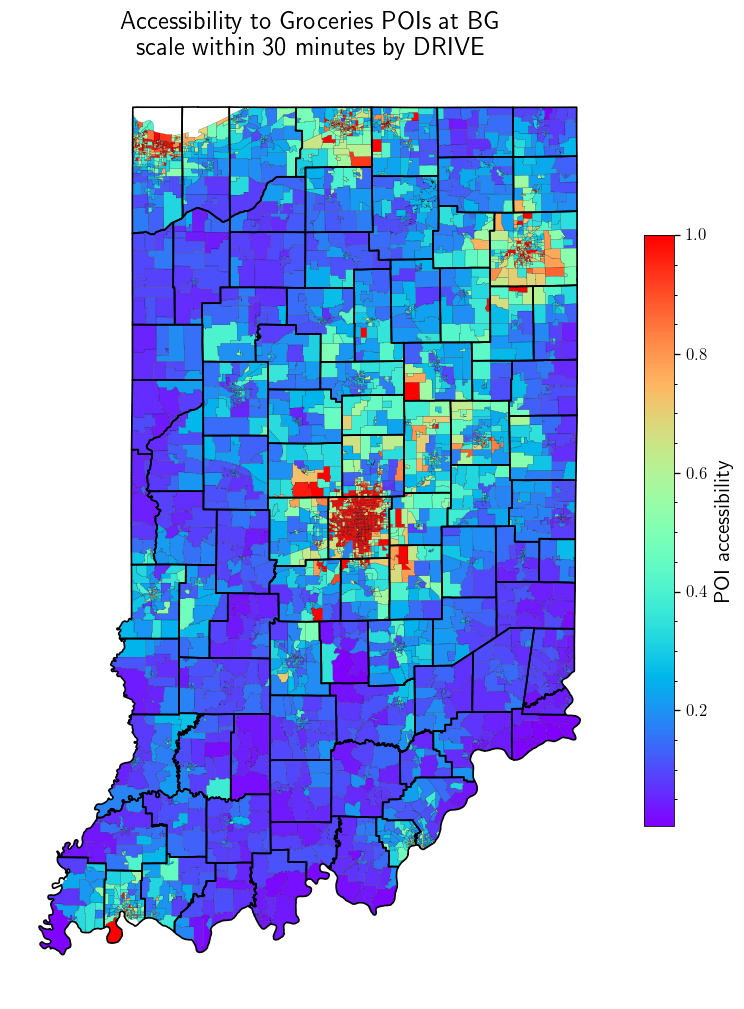

In [25]:
%time plot_map_poi_access('BG', 'DRIVE', 30, 'Groceries', vmax=1, poi_weight_method='VISITS')

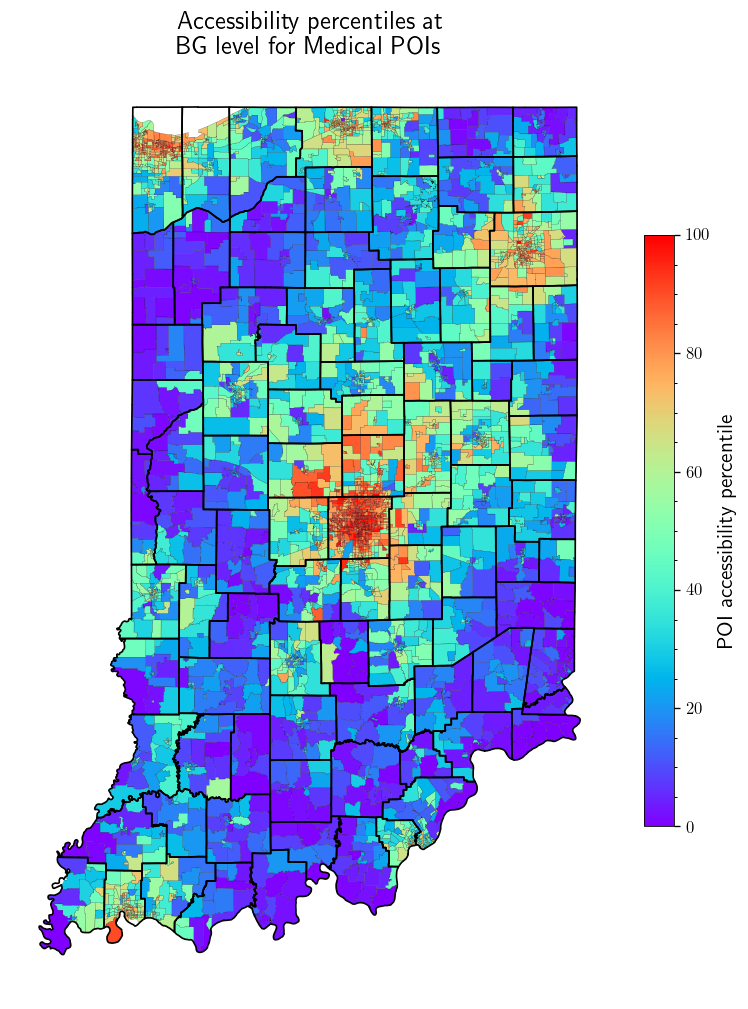

In [26]:
ax = U.plot(size=(8, 16), dpi=120, axoff=1, title='Accessibility percentiles at\nBG level for Medical POIs')
df = zones.merge(xs[xs.poi_kind=='Medical'].sort_values('access').reset_index(drop=True).assign(pctile=lambda df: df.index / len(df) * 100))
cnty = zones.query('scale=="COUNTY"')
df.plot(ax=ax, column='pctile', cmap='rainbow', legend=True, vmax=100,
        edgecolor='k', lw=0.1, legend_kwds=dict(
            shrink=0.4, label='POI accessibility percentile'))
cnty.plot(ax=ax, edgecolor='k', lw=1, facecolor='none');

/home/umni2/a/umnilab/users/verma99/anaconda3/envs/mk11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/umni2/a/umnilab/users/verma99/anaconda3/envs/mk11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/umni2/a/umnilab/users/verma99/anaconda3/envs/mk11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/umni2/a/umnilab/users/verma99/anaconda3/envs/mk11/lib/python3.11/site-packages/seaborn/_oldcore.py:1

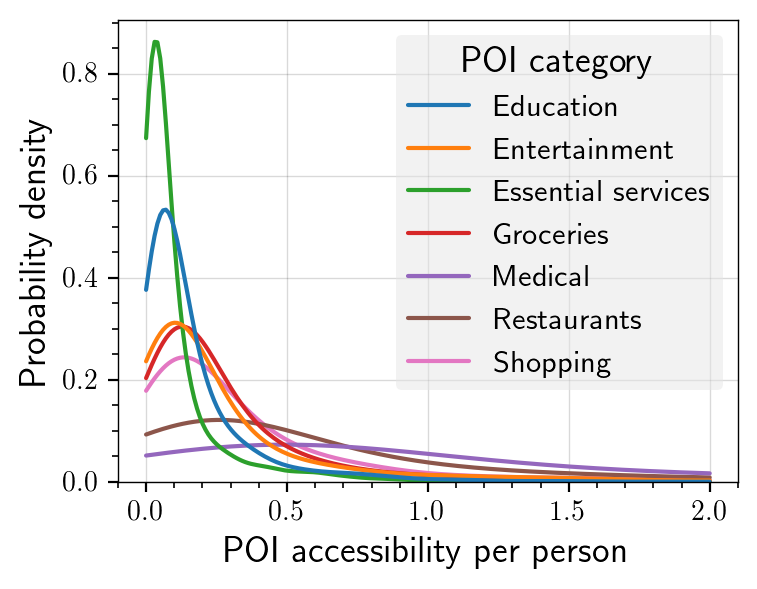

In [27]:
ax = U.plot(size=(4, 3), dpi=200)
title='Distribution of accessibility by POI kind'
sns.kdeplot(xs, x='access', hue='poi_kind', ax=ax, clip=(0, 2))
ax = U.plot(ax, xlab='POI accessibility per person', ylab='Probability density')
ax.get_legend().set_title('POI category');

In [28]:
# indy_cnty = cnty[cnty.name.isin(('Marion','Hamilton','Hendricks','Johnson','Madison','Hancock','Morgan','Boone','Shelby','Putnam','Brown'))].disp()
indy_cnty = zones.query('name == "Marion"').to_crs(CRS_M).disp()

1 rows x 6 cols; Memory: 0.0 MiB; CRS: EPSG:3857


geoid      name       aland    awater  \
      <object>  <object>     <int64>   <int64>   
4900     18097    Marion  1026408097  17377675   

                                               geometry       scale  
                                             <geometry>  <category>  
4900  POLYGON ((-9609832.152039 4825262.090051, -960...      COUNTY

In [29]:
import contextily as ctx

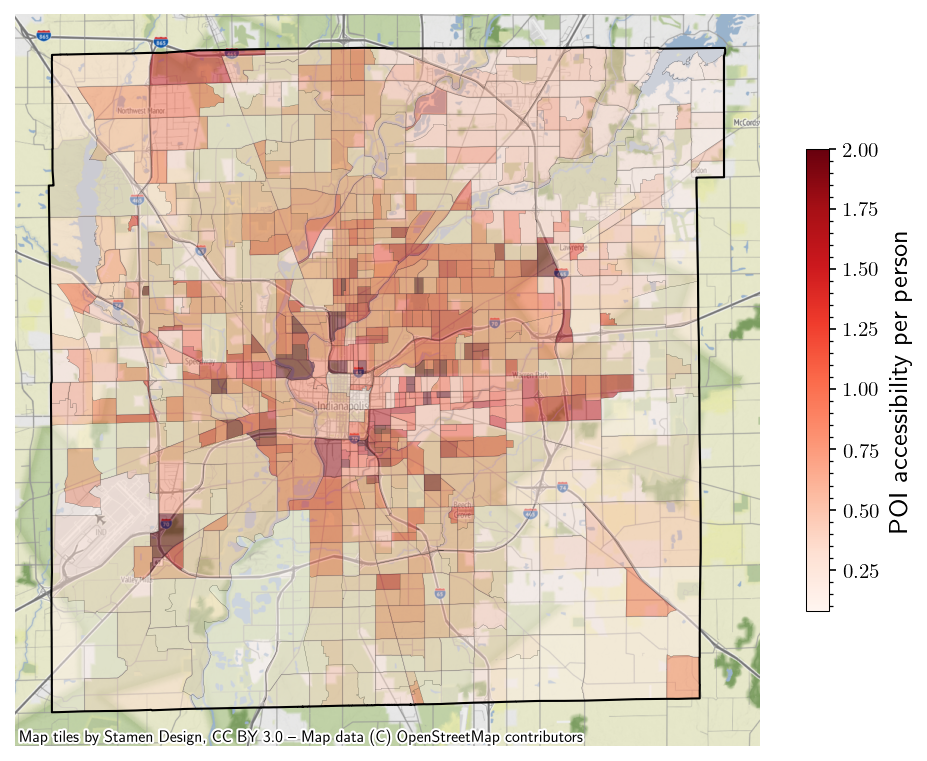

In [30]:
ax = U.plot(size=(8, 8), axoff=1)
indy_xs = (zones[['geoid','geometry']]
           .merge(xs.assign(cnty=xs.geoid.str[:5])
                  .query('poi_kind=="Groceries"')
                  .merge(indy_cnty['geoid'].rename('cnty')))
           .to_crs(CRS_M))
indy_xs.plot(ax=ax, column='access', cmap='Reds', legend=True,
            edgecolor='k', lw=0.1, vmax=2, alpha=0.5, legend_kwds=dict(
                shrink=0.5, label='POI accessibility per person'))
indy_cnty.plot(ax=ax, fc='none', ec='k', lw=1)
ctx.add_basemap(ax=ax, crs=CRS_M);

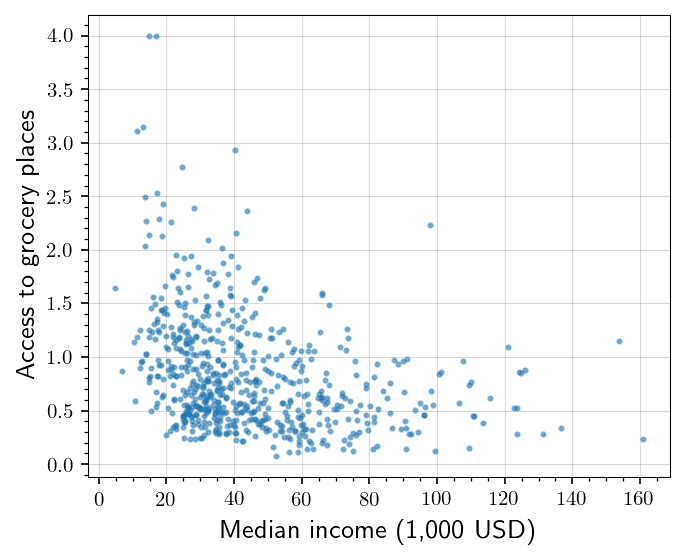

In [31]:
df = xs.merge(acs.assign(cnty=acs.geoid.str[:5]).merge(indy_cnty['geoid'].rename('cnty'))).query('poi_kind=="Groceries"')
ax = U.plot(size=(5, 4), xlab='Median income (1,000 USD)', ylab='Access to grocery places')
ax.scatter(df.inc_median/1e3, df.access.clip(0, 4), s=4, alpha=0.5);